In [45]:
import pickle
import re
from math import sqrt
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.display import HTML, display

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.gridspec as GS
from seaborn import PairGrid, heatmap, kdeplot, FacetGrid, scatterplot, cubehelix_palette
import cmocean.cm as cmo
import arviz as az

import pymc3 as pm

In [170]:
def create_smry(trc, labels, vname=['w']):
    ''' Conv fn: create trace summary for sorted forestplot '''
    dfsm = pm.summary(trc, varnames=vname)
    dfsm.rename(index={wi: lbl for wi, lbl in zip(dfsm.index, feature_labels)},
                inplace=True)
    #dfsm.sort_values('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.linspace(1, 0, len(dfsm))
    return dfsm


def custom_forestplot(df, ax, replace_bathy=True):
    ax.scatter(x=df['mean'], y=df.ypos, edgecolor='k', facecolor='white', zorder=2)
    ax.hlines(df.ypos, xmax=df['hpd_97.5'], xmin=df['hpd_2.5'],
              color='k', zorder=1, linewidth=3)
    ax.set_yticks(df.ypos)
    ax.set_yticklabels(df.index.tolist())
    ax.axvline(linestyle=':', color='k')
    ax.grid(axis='y', zorder=0)

    
def plot_pairwise_map(df, ax=None, annot=False):
    if ax is None:
        _, ax = pl.subplots(figsize=(20, 20))
    dfc = df.corr().iloc[1:, :-1]
    heatmap(dfc, vmin=-1, vmax=1, cmap=cmo.balance_r, annot=annot, annot_kws={'fontsize': 6},
            ax=ax, mask=np.triu(np.ones([dfc.shape[1]]*2), k=1), fmt='.1f',
           linewidths=0.5, linecolor='black')
    ax.set_facecolor('k')
    return ax


def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False,
                         add_label=True, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    mae = mean_absolute_error(y_obs, ppc_mean)
    r2 = r2_score(y_obs, ppc_mean)
    if add_label:
        scatter_lbl = scatter_kwds.pop('label', '')
        scatter_lbl = fr'{scatter_lbl}; {r2:.2f}; {mae:.2f}'
        ax.scatter(y_obs, ppc_mean, edgecolor='k', label=scatter_lbl, **scatter_kwds)
    else:
        ax.scatter(y_obs, ppc_mean, edgecolor='k', **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')
    ax.legend(loc='upper left')
    return ax


def plot_fits_w_estimates(y_obs, ppc, ax=None, legend=False):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean = ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    r2 = r2_score(y_obs, lik_mean)
    mae = mean_absolute_error(y_obs, lik_mean)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=40,
               color='w', marker='d', zorder=2);
    ax.scatter(ix, lik_mean[iy], label='model mean -- $r^2$=%.2f -- mae=%.2f' %(r2, mae),
               edgecolor='k', s=40, color='w', zorder=3)

    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    if legend:
        ax.legend(loc='upper left');
    return ax


def compute_fig_height(fig_width):
    golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
    return fig_width*golden_mean # height in inches


def latexify(fig_width=None, fig_height=None, columns=1, square=False):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    PNAS 1-column figure width should be 3.5"
    PNAS 2-column wide figures should be 4.49" or 7" (??)
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf
    
    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.43 if columns==1 else 4.49 # width in inches

    if fig_height is None:
        if square:
            fig_height = fig_width
        else:
            fig_height =  compute_fig_height(fig_width) # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    rcParams.update(params)

In [164]:
"""hshoe_mdl_dict[m_hshoe_510.model.name] = dict(model=m_hshoe_510.model,
                                              trace=m_hshoe_510.trace_,
                                              ppc_train=ppc_train_510,
                                              ppc_test=ppc_test_510)
"""
with open('./pickleJar/HSHOE_MDL_DICT.pkl', 'rb') as fb:
    hshoe_mdl_dict = pickle.load(fb)

In [6]:
with open('./pickleJar/BNNAphySplitDataSets.pkl', 'rb') as fb:
    datadict = pickle.load(fb)
X_s_train = datadict['x_train_s']
y_train = datadict['y_train']
X_s_test = datadict['x_test_s']
y_test = datadict['y_test']

In [7]:
predictor_renamedict = {'log10_etopo2_s': 'dep',
                        'oisst_s': 'sst', 'solz_s': 'solz',
                        'PC1_s': 'pc1', 'PC2_s': 'pc2', 'PC3_s': 'pc3',
                        'PC4_s': 'pc4', 'PC5_s': 'pc5', 'PC6_s': 'pc6'}

In [8]:
X_s_train.rename(columns= predictor_renamedict, inplace=True)

In [9]:
X_s_test.rename(columns=predictor_renamedict, inplace=True)

In [10]:
y_train.rename(columns={k: k.replace('_', '(') + ')' for k in y_train.columns},
              inplace=True)

In [11]:
y_test.rename(columns={k: k.replace('_', '(') + ')' for k in y_train.columns},
              inplace=True)

In [12]:
feature_labels=X_s_train.columns.tolist()

HEATMAP

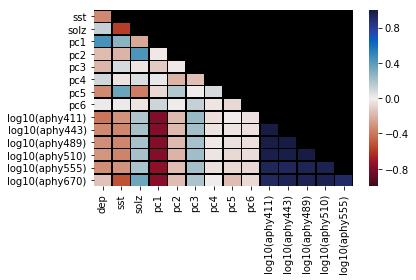

In [13]:
#latexify(fig_height=3.4)
f, ax = pl.subplots()
ax = PlotHeatMap(pd.concat((X_s_train, y_train), axis=1), ax=ax,)
f.tight_layout()
f.savefig('./figJar/aphy_heatmap.pdf')

FORESTPLOTS

In [14]:
dfs_411 = create_smry(hshoe_mdl_dict['hshoe_aphy411']['trace'], feature_labels)
dfs_510 = create_smry(hshoe_mdl_dict['hshoe_aphy510']['trace'], feature_labels)
dfs_670 = create_smry(hshoe_mdl_dict['hshoe_aphy670']['trace'], feature_labels)

In [15]:
dfs_411

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat,ypos
dep,-0.112370,0.025256,0.000399,-0.162076,-0.062002,4324.501990,1.000079,1.000
sst,-0.115680,0.025130,0.000375,-0.165954,-0.067985,4620.639593,0.999994,0.875
solz,0.048777,0.027500,0.000404,-0.003446,0.102845,3816.939242,0.999932,0.750
pc1,-0.226821,0.024161,0.000392,-0.272527,-0.176619,4034.419000,0.999785,0.625
pc2,-0.147247,0.024301,0.000388,-0.193531,-0.099400,3604.016826,0.999787,0.500
pc3,0.057794,0.019048,0.000228,0.020921,0.095516,6786.710712,0.999873,0.375
pc4,-0.035288,0.019652,0.000232,-0.072422,0.003546,5738.412490,0.999812,0.250
pc5,0.035664,0.023217,0.000355,-0.009293,0.081219,4175.971229,0.999963,0.125
pc6,0.007262,0.017428,0.000210,-0.027652,0.040816,6789.464688,0.999851,0.000


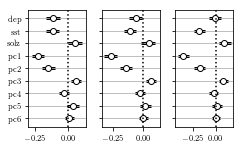

In [171]:
latexify()
f, axs = pl.subplots(ncols=3, sharey=True,)
custom_forestplot(dfs_411, ax=axs[0])
custom_forestplot(dfs_510, ax=axs[1])
custom_forestplot(dfs_670, ax=axs[2])
f.tight_layout()
f.savefig('./figJar/HSReg_forest_test.pdf')


SCATTERPLOTS

In [21]:
hshoe_mdl_dict.keys()

dict_keys(['hshoe_aphy411', 'hshoe_aphy443', 'hshoe_aphy489', 'hshoe_aphy510', 'hshoe_aphy555', 'hshoe_aphy670'])

In [24]:
bands = [411, 443, 489, 510, 555, 670]
ppc_test_dict = {l: hshoe_mdl_dict['hshoe_aphy%d' %l]['ppc_test'] for l in bands}

In [65]:
cmap=cubehelix_palette(n_colors=6, as_cmap=True)

In [67]:
cmap.colors[0]

array([0.93126922, 0.82019218, 0.7971481 , 1.        ])

In [92]:
from matplotlib.colors import Normalize
cmap = cm.get_cmap('gist_yarg')
normalize = Normalize(vmin=min(bands), vmax=max(bands))
colors = [cmap(normalize(value)) for value in bands]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

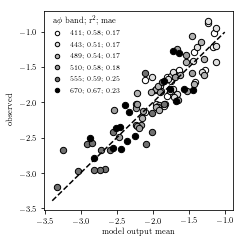

In [161]:
latexify(square=True)
cmap=cubehelix_palette(n_colors=6, as_cmap=True)
f, ax_ = pl.subplots()
for i, band in enumerate(bands):
    plot_obs_against_ppc(y_test['log10_aphy%d' %band], ppc_test_dict[band],
                         s=40, ax=ax_, c=colors[i], label='%d' % band
                         #label=r'$a\phi%d \rightarrow$' % band,
                        ) 
    #plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, s=75,
    #                     color='steelblue', ax=ax_, label=r'$a\phi443 \rightarrow$', 
    #                    )
    #plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, s=75,
    #                     color='cyan', ax=ax_, label=r'$a\phi489 \rightarrow$', )
    #plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, s=75,
    #                     color='orange', ax=ax_, label=r'$a\phi510 \rightarrow$')
    #plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, s=75, 
    #                     color='brown', ax=ax_, label=r'$a\phi555 \rightarrow$')
    #plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, s=75,
    #                     color='red', ax=ax_, label=r'$a\phi670 \rightarrow$')
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend(title=r'a$\phi$ band; r$^2$; mae', fontsize=7, loc='upper left',
   frameon=False, markerscale=0.7, markerfirst=True)
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
f.tight_layout()
f.savefig('./figJar/HorseShoePrior_aphi_test_sets_scatter.pdf', format='pdf', dpi=300)

## PPCPLOTS

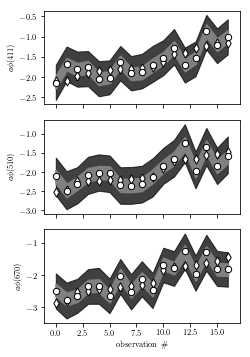

In [185]:
latexify(fig_height=5, )
f, ax = pl.subplots(nrows=3, sharex=True)
for axi, band in zip(ax, [411, 510, 670]):
    plot_fits_w_estimates(y_obs=y_test['log10_aphy%d' % band],
                          ppc=ppc_test_dict[band], ax=axi)
    axi.set_ylabel(r'$a\phi(%d)$' % band)
axi.set_xlabel(r'observation \#');
f.tight_layout()
f.savefig('./figJar/HorseShoePrior_aphi_test_sets_HDI.pdf')

### MODEL PLATE

In [172]:
with open('./pickleJar/Hshoe_example_model.pkl', 'rb') as fb:
    mhsoe_mdl = pickle.load(fb)

'3.6'